<a href="https://colab.research.google.com/github/TheArslan23/Portfolio/blob/master/SENTIMENT%20ANALYSIS%20ON%20TWEETS/Twitter_Airline_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
!pip install contractions

In [99]:
# import the libraries
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
import matplotlib.pyplot as plt
import numpy as np
import re
import contractions
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import os

import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [100]:
df = pd.read_csv("Tweets.csv")

In [101]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [103]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [104]:
df.isnull().sum()

,0
tweet_id,0
airline_sentiment,0
airline_sentiment_confidence,0
negativereason,5462
negativereason_confidence,4118
airline,0
airline_sentiment_gold,14600
name,0
negativereason_gold,14608
retweet_count,0


# Preprocessing the Tweets

1. droping bad data and picking the features

In [105]:
# finding the low confidence data
confidence_threshold = 0.6
df.query('airline_sentiment_confidence < @confidence_threshold').index

Index([    1,   114,   142,   183,   309,   349,   403,   462,   488,   495,
       ...
       13930, 13997, 14020, 14075, 14078, 14261, 14297, 14414, 14530, 14635],
      dtype='int64', length=238)

In [106]:
# dropping the low confidence data
df = df.drop(df.query('airline_sentiment_confidence < @confidence_threshold').index , axis = 0).reset_index(drop = True)

# selecting the features we need
df = pd.concat([df['text'], df['airline_sentiment']], axis = 1)
df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica I didn't today... Must mean I n...,neutral
2,@VirginAmerica it's really aggressive to blast...,negative
3,@VirginAmerica and it's a really big bad thing...,negative
4,@VirginAmerica seriously would pay $30 a fligh...,negative
...,...,...
14397,@AmericanAir right on cue with the delays👌,negative
14398,@AmericanAir leaving over 20 minutes Late Flig...,negative
14399,@AmericanAir Please bring American Airlines to...,neutral
14400,"@AmericanAir you have my money, you change my ...",negative


In [107]:
df.isna().sum().sum()

0

In [108]:
df['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9113
neutral,2997
positive,2292


In [109]:
# convert Sentiments to 0,1,2
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0

In [110]:
# Apply convert_Sentiment function
df.airline_sentiment = df.airline_sentiment.apply(lambda x : convert_Sentiment(x))

2.lowercasing

In [111]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'][5:15]

,text
5,"@virginamerica yes, nearly every time i fly vx..."
6,@virginamerica really missed a prime opportuni...
7,"@virginamerica well, i didn't…but now i do! :-d"
8,"@virginamerica it was amazing, and arrived an ..."
9,@virginamerica did you know that suicide is th...
10,@virginamerica i &lt;3 pretty graphics. so muc...
11,@virginamerica this is such a great deal! alre...
12,@virginamerica @virginmedia i'm flying your #f...
13,@virginamerica thanks!
14,@virginamerica sfo-pdx schedule is still mia.


3. expanding contraction

In [112]:
df['text'] = df['text'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
df['text'][2]

'@virginamerica it is really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

removing @usernames, url, html tags, punctuations and numerical values and emojis

In [113]:
# remove username
df['text'] = df['text'].str.replace('([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)','', regex=True)
# remove url
df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+','', regex=True)
# remove html
df['text'] = df['text'].str.replace(r'<.*?>','', regex=True)
# remove numerical value
df['text'] = df['text'].str.replace('[\d-]','', regex=True)
# remove punctuations
df['text'] = df['text'].str.replace('[^\w\s]','', regex=True)

df['text'][2]

' it is really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse'

In [114]:
df['text'][14398]

' leaving over  minutes late flight no warnings or communication until we were  minutes late flight that is called shitty customer svc'

In [115]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

4.Lemmatizing

In [116]:
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['text']

,text
0,what said
1,i did not today must mean i need to take anoth...
2,it is really aggressive to blast obnoxious ent...
3,and it is a really big bad thing about it
4,seriously would pay a flight for seat that did...
...,...
14397,right on cue with the delay
14398,leaving over minute late flight no warning or ...
14399,please bring american airline to
14400,you have my money you change my flight and do ...


5.stemming

In [117]:
stem = PorterStemmer()
df['text'] = df['text'].apply(lambda x: " ".join([stem.stem(word) for word in x.split()]))
df['text']

,text
0,what said
1,i did not today must mean i need to take anoth...
2,it is realli aggress to blast obnoxi entertain...
3,and it is a realli big bad thing about it
4,serious would pay a flight for seat that did n...
...,...
14397,right on cue with the delay
14398,leav over minut late flight no warn or commun ...
14399,pleas bring american airlin to
14400,you have my money you chang my flight and do n...


In [118]:
df['text'][2]

'it is realli aggress to blast obnoxi entertain in your guest face amp they have littl recours'

In [119]:
df['text'][14398]

'leav over minut late flight no warn or commun until we were minut late flight that is call shitti custom svc'

6.removing stopwords

In [120]:
import nltk
nltk.download('stopwords')
# Download the 'stopwords' resource
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text
0,said
1,today must mean need take anoth trip
2,realli aggress blast obnoxi entertain guest fa...
3,realli big bad thing
4,serious would pay flight seat thi play realli ...
...,...
14397,right cue delay
14398,leav minut late flight warn commun minut late ...
14399,pleas bring american airlin
14400,money chang flight answer phone ani suggest ma...


In [121]:
df['text'][3]

'realli big bad thing'

In [122]:
x = df['text']
y = df['airline_sentiment']

In [129]:
df_original = pd.read_csv("Tweets.csv")
df = pd.DataFrame({'text': df_original['text'], 'airline_sentiment': df_original['airline_sentiment'], 'airline': df_original['airline']})


In [130]:
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size
plt.rcParams["figure.autolayout"] = True




8.0
6.0


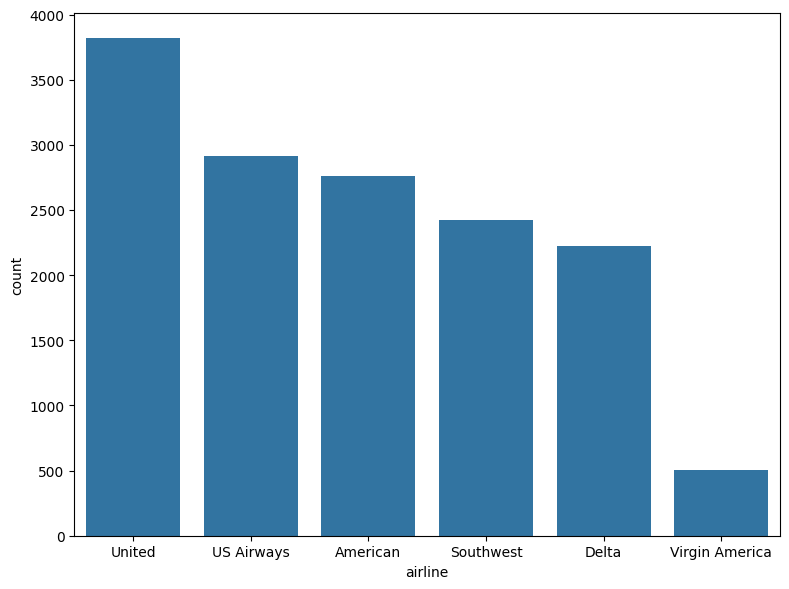

In [131]:
ax = sns.countplot(x = 'airline', data = df, order = df.airline.value_counts().index)

<Axes: ylabel='count'>

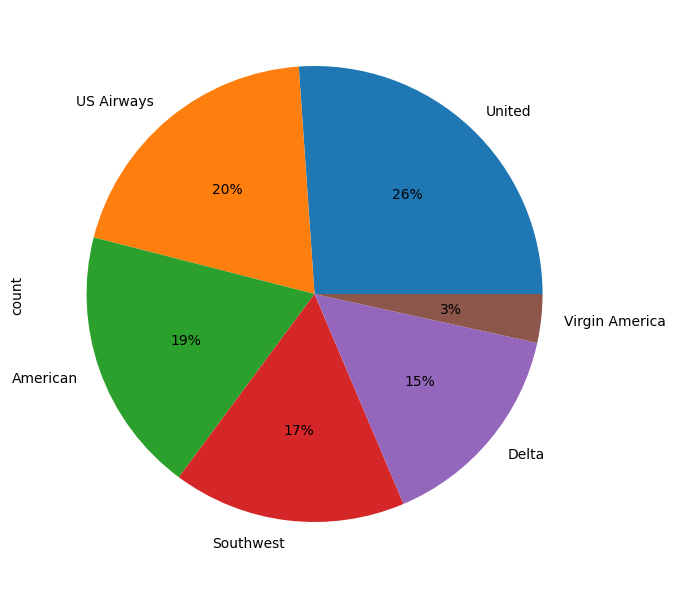

In [132]:
df.airline.value_counts().plot(kind = 'pie', autopct = '%1.0f%%')

<Axes: xlabel='airline_sentiment'>

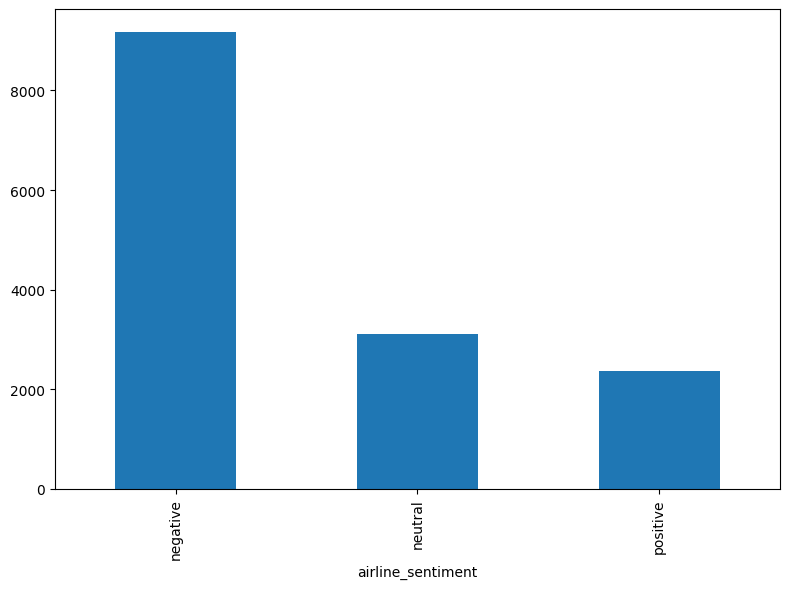

In [133]:
airline_sentiment = df.groupby(["airline_sentiment"]).airline_sentiment.count()
airline_sentiment.plot(kind = 'bar')


<Axes: ylabel='count'>

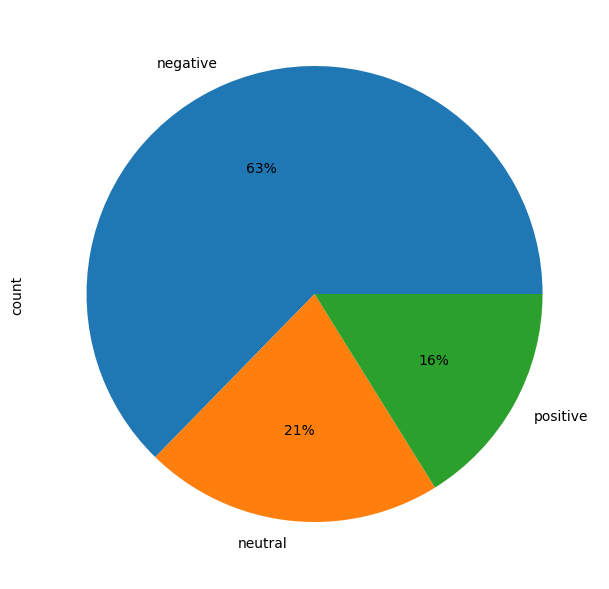

In [134]:
df.airline_sentiment.value_counts().plot(kind = 'pie', autopct = '%1.0f%%')

<Axes: xlabel='airline'>

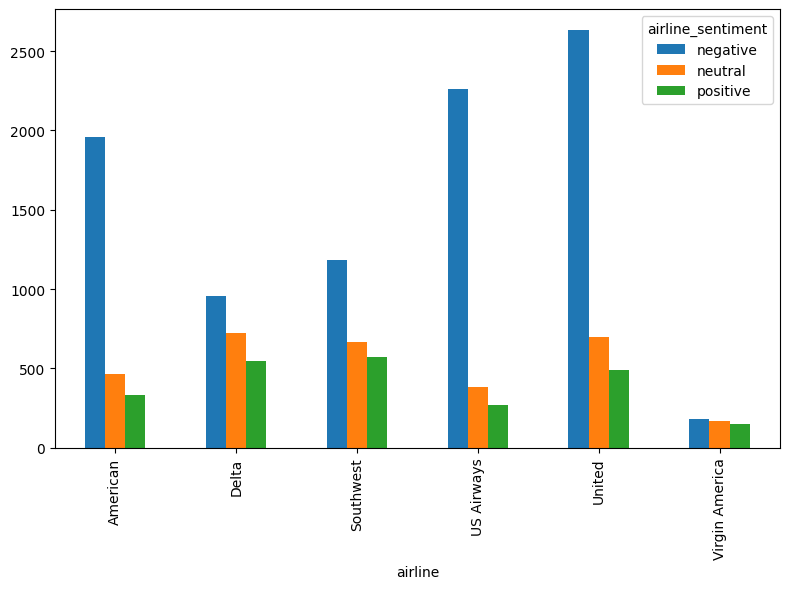

In [135]:
airline_sentiment = df.groupby(["airline", "airline_sentiment"]).airline_sentiment.count().unstack()
airline_sentiment.plot(kind = 'bar') # stacked = True

<Axes: xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

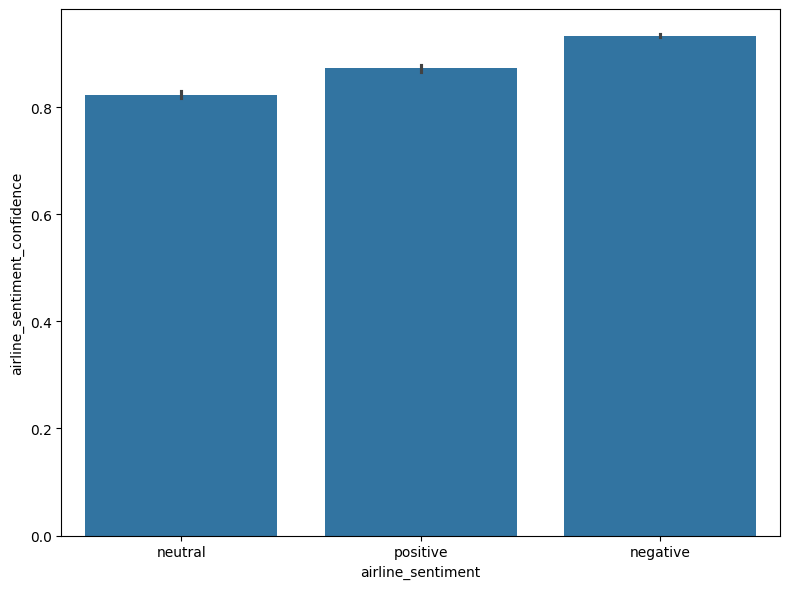

In [139]:
df = pd.read_csv("Tweets.csv")
sns.barplot(x = 'airline_sentiment', y = 'airline_sentiment_confidence', data = df)

<ipython-input-140-6e39c91de49e>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


[Text(0, 0, 'Customer Service Issue'),
 Text(1, 0, 'Late Flight'),
 Text(2, 0, "Can't Tell"),
 Text(3, 0, 'Cancelled Flight'),
 Text(4, 0, 'Lost Luggage'),
 Text(5, 0, 'Bad Flight'),
 Text(6, 0, 'Flight Booking Problems'),
 Text(7, 0, 'Flight Attendant Complaints'),
 Text(8, 0, 'longlines'),
 Text(9, 0, 'Damaged Luggage')]

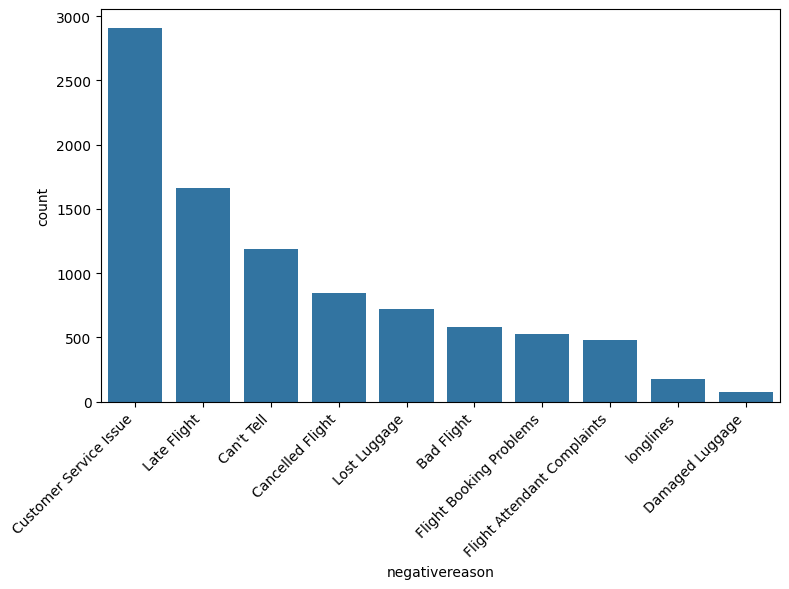

In [140]:
ax = sns.countplot(x = 'negativereason', data = df, order = df.negativereason.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

<Axes: ylabel='count'>

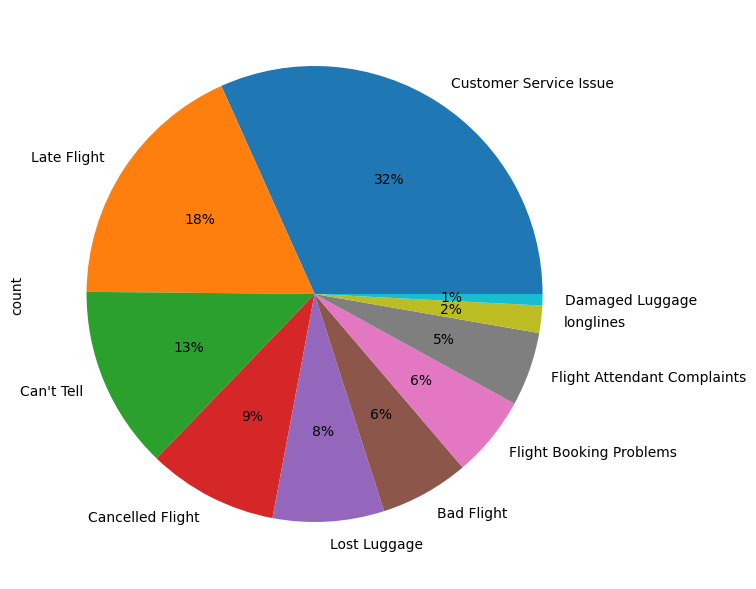

In [141]:
df.negativereason.value_counts().plot(kind = 'pie', autopct = '%1.0f%%')

In [142]:
positive=df[df['airline_sentiment']=='positive'].text
neutral=df[df['airline_sentiment']=='neutral'].text
negative=df[df['airline_sentiment']=='negative'].text

(-0.5, 1599.5, 719.5, -0.5)

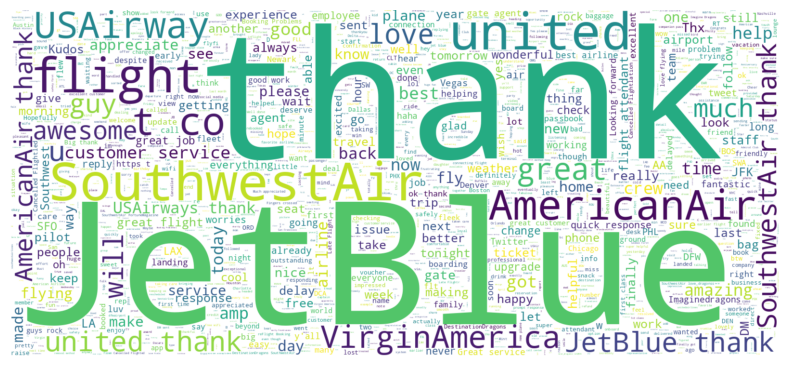

In [143]:
world_cloud_postive=WordCloud(min_font_size=3,max_words=3200,width=1600,height=720, background_color='white').generate("".join(positive))
plt.imshow(world_cloud_postive,interpolation='bilinear')
plt.axis('off')

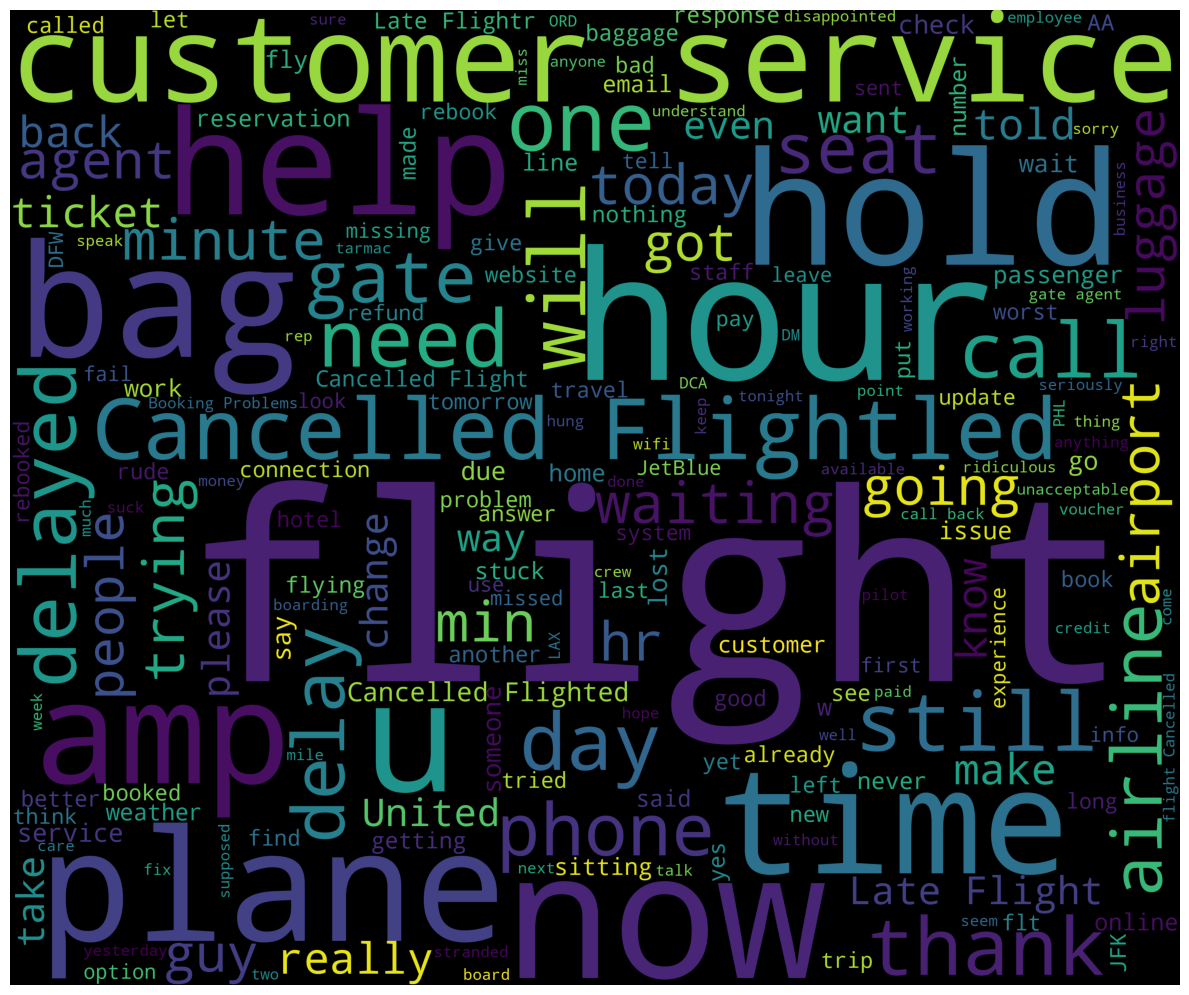

In [145]:
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Lets try and calculate the highest frequency words in postive sentimental tweets

In [146]:
# Calculate highest frequency words in positive tweets
def freq(str):

    # break the string into list of words
    str = str.split()
    str2 = []

    # loop till string values present in list str
    for i in str:

        # checking for the duplicacy
        if i not in str2:

            # insert value in str2
            str2.append(i)

    for i in range(0, len(str2)):
        if(str.count(str2[i])>50):
            print('Frequency of', str2[i], 'is :', str.count(str2[i]))

print(freq(cleaned_word))

Frequency of it's is : 240
Frequency of really is : 153
Frequency of to is : 5966
Frequency of in is : 1644
Frequency of your is : 1182
Frequency of &amp; is : 468
Frequency of they is : 444
Frequency of have is : 1142
Frequency of and is : 2685
Frequency of a is : 3087
Frequency of bad is : 113
Frequency of about is : 364
Frequency of it is : 982
Frequency of would is : 330
Frequency of pay is : 105
Frequency of flight is : 1915
Frequency of for is : 2665
Frequency of seats is : 112
Frequency of that is : 997
Frequency of didn't is : 140
Frequency of this is : 745
Frequency of the is : 3929
Frequency of only is : 216
Frequency of flying is : 147
Frequency of is is : 1959
Frequency of still is : 395
Frequency of I is : 3375
Frequency of from is : 722
Frequency of last is : 205
Frequency of couldn't is : 70
Frequency of sit is : 57
Frequency of my is : 2225
Frequency of seat is : 143
Frequency of due is : 204
Frequency of two is : 155
Frequency of on is : 2593
Frequency of of is : 1514


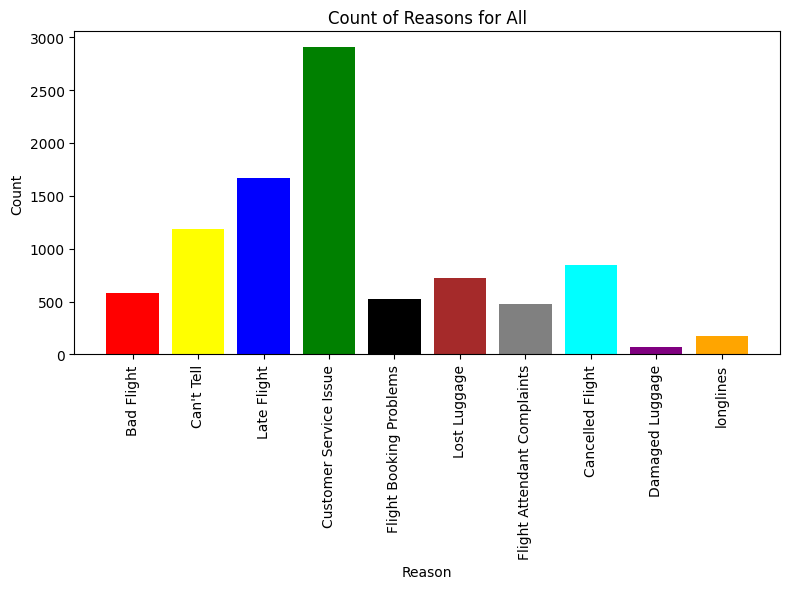

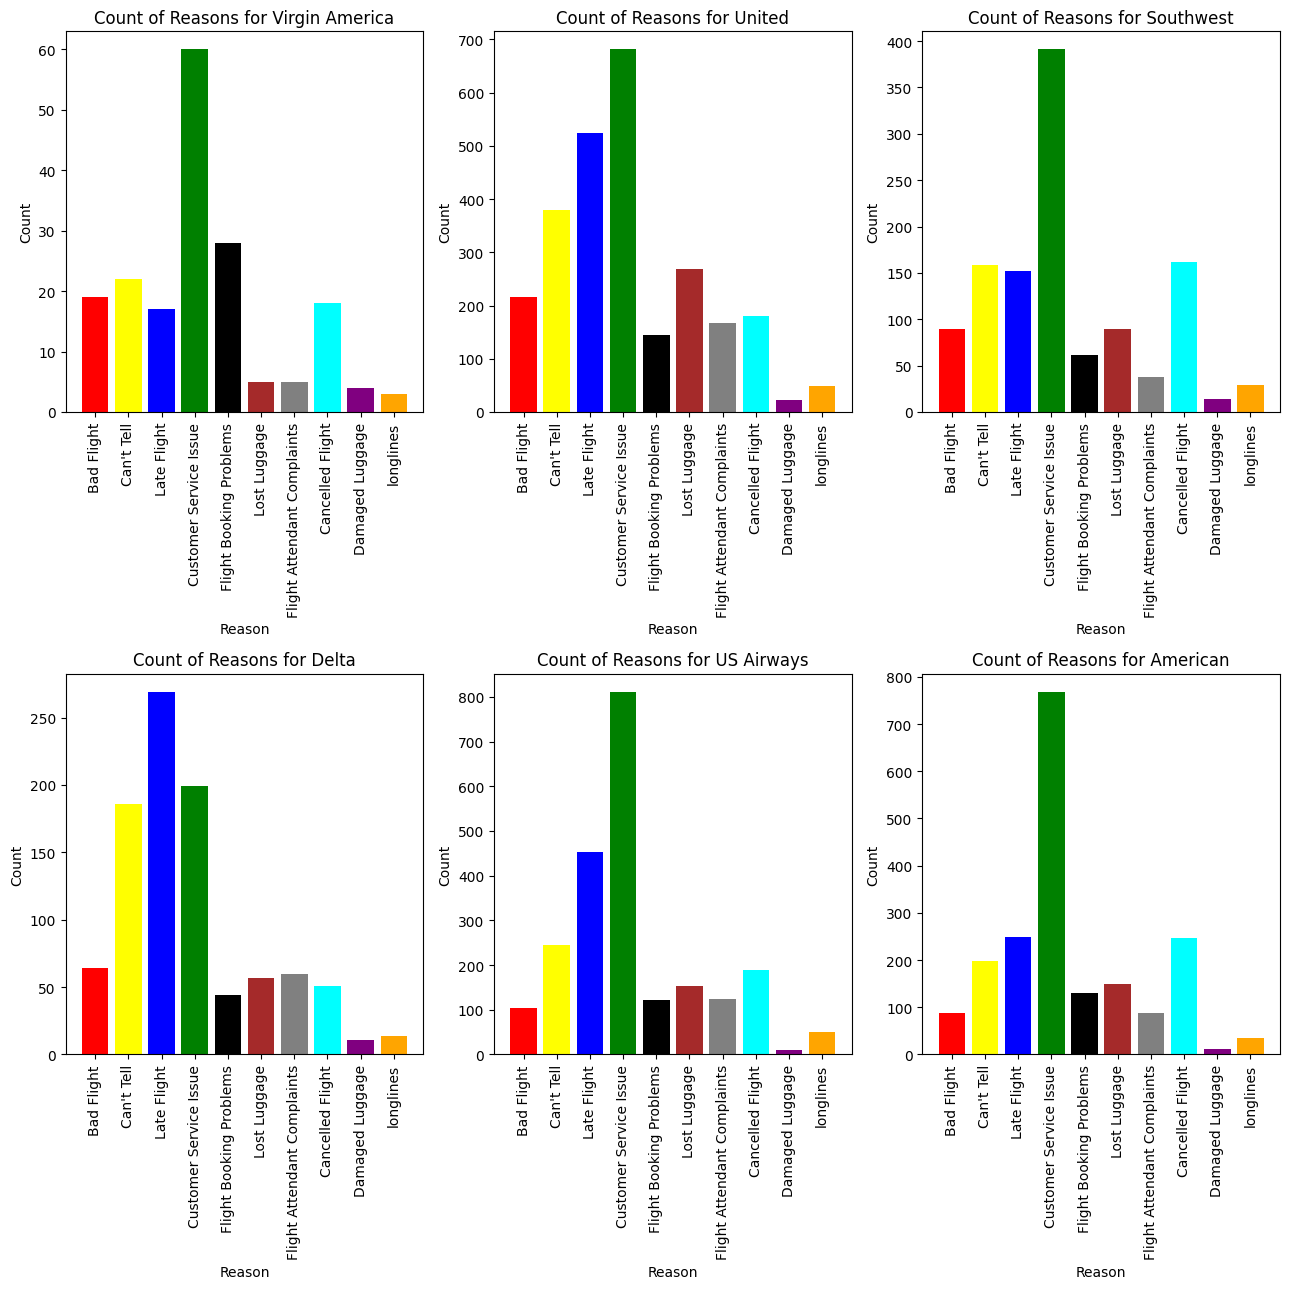

In [153]:
#get the number of negative reasons
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):

    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

df = pd.read_csv("Tweets.csv")
plot_reason('All')
plt.figure(2,figsize=(13, 13))
# Define the airline variable using the unique values from the 'airline' column of the DataFrame.
airline = df['airline'].unique()
# Convert the numpy array to a list to use the .index() method
airline_list = airline.tolist()
for i in airline_list:
    # Use the .index() method on the list
    indices = airline_list.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

In [154]:
date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

In [155]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

In [156]:
df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

In [157]:
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [158]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

In [160]:
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

Accuracy of DecisionTreeClassifieris 0.6871584699453552
              precision    recall  f1-score   support

    negative       0.80      0.80      0.80      1880
     neutral       0.45      0.41      0.43       626
    positive       0.55      0.59      0.57       422

    accuracy                           0.69      2928
   macro avg       0.60      0.60      0.60      2928
weighted avg       0.68      0.69      0.69      2928



<Figure size 800x600 with 0 Axes>

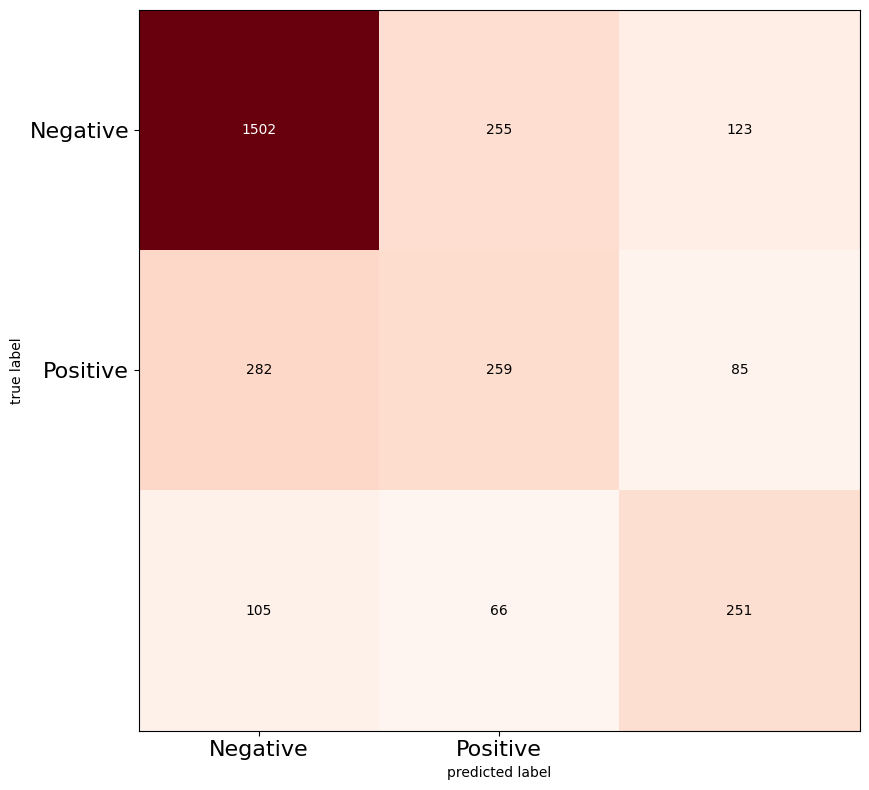

Accuracy of RandomForestClassifieris 0.7640027322404371
              precision    recall  f1-score   support

    negative       0.90      0.81      0.86      2098
     neutral       0.44      0.56      0.49       456
    positive       0.60      0.73      0.66       374

    accuracy                           0.76      2928
   macro avg       0.65      0.70      0.67      2928
weighted avg       0.79      0.76      0.77      2928



<Figure size 800x600 with 0 Axes>

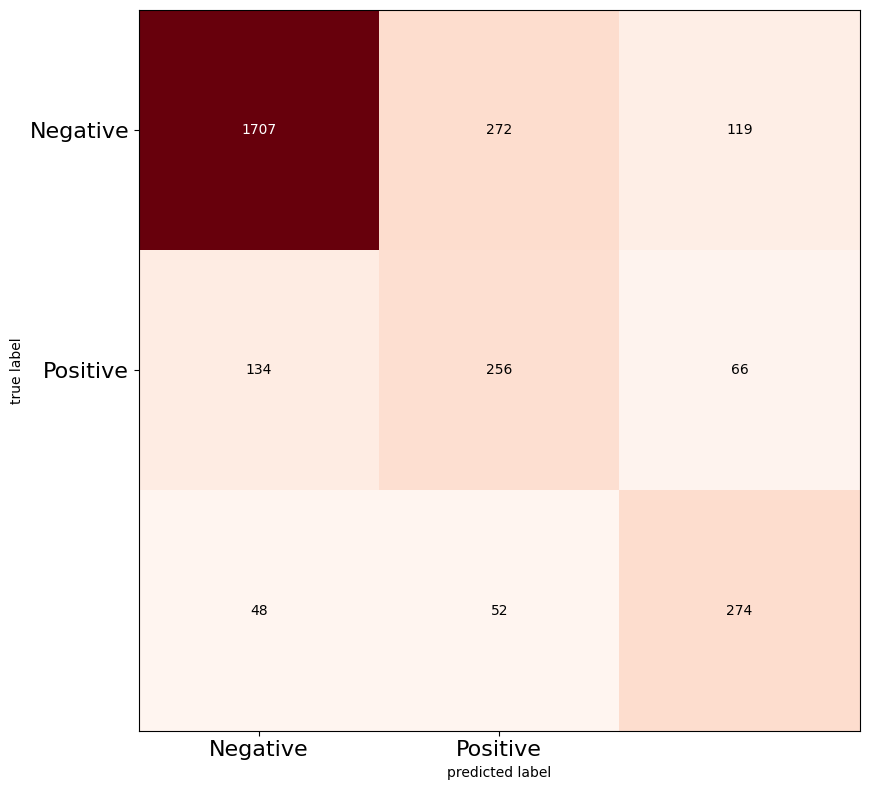

In [164]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['airline_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['airline_sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['airline_sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
    print(classification_report(pred,test['airline_sentiment']))
    cm=confusion_matrix(pred , test['airline_sentiment'])
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
    plt.xticks(range(2), ['Negative', 'Positive'], fontsize=16, color='black') # Update xtick labels
    plt.yticks(range(2), ['Negative', 'Positive'], fontsize=16) # Update ytick labels
    plt.show()